In [1]:
with open('karangan', 'r') as fopen:
    karangan = fopen.read().split('\n')
with open('ringkasan', 'r') as fopen:
    ringkasan = fopen.read().split('\n')

In [2]:
vocab_inputs = []; vocab_predict = []

# we tokenized each sentence in both dataset, turn into vocabulary.
for i in xrange(len(karangan)):
    vocab_inputs += karangan[i].split(); vocab_predict += ringkasan[i].split()

# Then we sorted our tokenized words from highest freq to lowest freq.
vocab_inputs = sorted(vocab_inputs,key = vocab_inputs.count,reverse = True)
vocab_predict = sorted(vocab_predict,key = vocab_predict.count,reverse = True)

d1 = dict((k,v) for v,k in enumerate(reversed(vocab_inputs)))
d2 = dict((k,v) for v,k in enumerate(reversed(vocab_predict)))

# Then we turned our sorted words into unique words, while maintaining the position of sorting.
vocab_inputs = ['PAD', 'EOS'] + sorted(d1, key = d1.get, reverse = True)
vocab_predict = ['PAD', 'EOS'] + sorted(d2, key = d2.get, reverse = True)

print 'vocab size for inputs: ' + str(len(vocab_inputs))
print 'vocab size for predict: ' + str(len(vocab_predict))

# Then turned into dictionary {'husein': 0, 'suka': 1.. n}
dict_inputs = dict(zip(vocab_inputs, [i for i in xrange(len(vocab_inputs))]))
dict_predict = dict(zip(vocab_predict, [i for i in xrange(len(vocab_predict))]))

vocab size for inputs: 430
vocab size for predict: 165


In [3]:
split_karangan = []
for i in xrange(len(karangan)):
    split_karangan.append(karangan[i].split())
    
greatestvalue_karangan = 0
for i in xrange(len(split_karangan)):
    if len(split_karangan[i]) > greatestvalue_karangan:
        greatestvalue_karangan = len(split_karangan[i])
        
# need to add one because our decoder need to include EOS
greatestvalue_karangan += 1

print 'longest sentence in our karangan dataset: ' + str(greatestvalue_karangan) + ' patah perkataan'

longest sentence in our karangan dataset: 304 patah perkataan


We got our vocab and batch size, now we are ready to do our training

Now we import our tensorflow and design our RNN with attention model

I'm still using Tensorflow 0.12 and will use most of the API from Tensorflow to make it short.

0.12, API for LSTM tf.nn.rnn_cell.LSTMCell

0.12, API for attention model tf.contrib.legacy_seq2seq.embedding_attention_seq2seq

1.X, I have no idea, a lot of naming changed in 1.X, so I am not willing myself to migrate 1.X

In [4]:
import numpy as np
import tensorflow as tf

size_layers = 256
num_layers = 2

sess = tf.InteractiveSession()

encoder_inputs = tf.placeholder(shape = [greatestvalue_karangan], dtype = tf.int32)
decoder_inputs = tf.placeholder(shape = [greatestvalue_karangan], dtype = tf.int32)
decoder_targets = tf.placeholder(shape = [greatestvalue_karangan], dtype = tf.int32)

cell = tf.nn.rnn_cell.LSTMCell(size_layers)
cell = tf.nn.rnn_cell.MultiRNNCell([cell] * num_layers)

outputs, state = tf.nn.seq2seq.embedding_attention_seq2seq(
    encoder_inputs = [encoder_inputs],
    decoder_inputs = [decoder_inputs],
    cell = cell,
    num_encoder_symbols = len(vocab_inputs),
    num_decoder_symbols = len(vocab_inputs),
    embedding_size = size_layers)

decoder_logits = tf.contrib.layers.linear(outputs, len(vocab_predict))

decoder_prediction = tf.argmax(decoder_logits, 2)

# this might very costly if you have very large vocab
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(
    labels = tf.one_hot(decoder_targets, depth = len(vocab_predict), dtype = tf.float32),
    logits = decoder_logits)

loss = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(0.001).minimize(loss)

sess.run(tf.global_variables_initializer())

In [5]:
epoch = 50
LOSS = []

def feed(text, karangan = True):
    text_int = []
    if karangan:
        text_int_decode = [1]
    strings = text.split()
    for i in xrange(greatestvalue_karangan):
        try:
            if karangan:
                text_int.append(dict_inputs[strings[i]])
                text_int_decode.append(dict_inputs[strings[i]])
            else:
                text_int.append(dict_predict[strings[i]])
        except:
            text_int.append(0)
            if karangan:
                text_int_decode.append(0)
                
    text_int[greatestvalue_karangan - 1] = 1
    
    if karangan:
        del text_int_decode[len(text_int_decode) - 1]
        return text_int, text_int_decode
    else:
        return text_int

In [6]:
import time

for q in xrange(epoch):
    total_loss = 0
    lasttime = time.time()
    
    for w in xrange(len(karangan)):
        input_seq_encode, input_seq_decode = feed(karangan[w], karangan = True)
        output_seq = feed(ringkasan[w], karangan = False)
        _, losses = sess.run([optimizer, loss], 
                             feed_dict = {encoder_inputs : input_seq_encode, decoder_inputs : input_seq_decode,
                                         decoder_targets : output_seq })
        total_loss += losses
        
    total_loss = total_loss / (len(karangan) * 1.0)
    LOSS.append(total_loss)
    print 'epoch: ' + str(q + 1) + ', total loss: ' + str(total_loss) + ', s/epoch: ' + str(time.time() - lasttime)

epoch: 1, total loss: 5.04089991252, s/epoch: 0.602192878723
epoch: 2, total loss: 4.38069883982, s/epoch: 0.541996955872
epoch: 3, total loss: 3.19136460622, s/epoch: 0.543068885803
epoch: 4, total loss: 2.6433309714, s/epoch: 0.541651964188
epoch: 5, total loss: 2.25960429509, s/epoch: 0.54180598259
epoch: 6, total loss: 1.74249974887, s/epoch: 0.541329860687
epoch: 7, total loss: 1.7214884758, s/epoch: 0.539263963699
epoch: 8, total loss: 1.54625721773, s/epoch: 0.537240982056
epoch: 9, total loss: 1.51467525959, s/epoch: 0.542845010757
epoch: 10, total loss: 1.45189758142, s/epoch: 0.539931058884
epoch: 11, total loss: 1.38198816776, s/epoch: 0.54217505455
epoch: 12, total loss: 1.3495409886, s/epoch: 0.542634010315
epoch: 13, total loss: 1.29773588975, s/epoch: 0.664098024368
epoch: 14, total loss: 1.24894432227, s/epoch: 0.594213008881
epoch: 15, total loss: 1.20931470394, s/epoch: 0.539052009583
epoch: 16, total loss: 1.16436549028, s/epoch: 0.557450056076
epoch: 17, total loss:

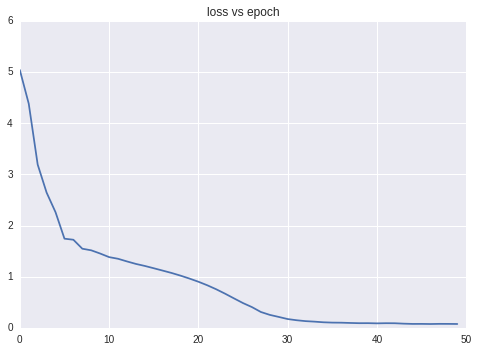

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

plt.plot([i for i in xrange(len(LOSS))], LOSS)
plt.title('loss vs epoch')
plt.show()

In [10]:
def label_to_text(label):
    string = ''
    for i in xrange(len(label)):
        if label[i] == 0 or label[i] == 1:
            continue
        string += vocab_predict[label[i]] + ' '
    return string

for i in xrange(len(karangan)):
    input_seq_encode, input_seq_decode = feed(karangan[i], karangan = True)
    predict = sess.run(decoder_prediction, 
                       feed_dict = {encoder_inputs : input_seq_encode, decoder_inputs : input_seq_decode})
    
    print 'karangan: ' + str(i + 1) + '\n'
    print 'actual text: ' + ringkasan[i] + '\n'
    print 'predict text: ' + str(label_to_text(predict[0])) + '\n\n'

karangan: 1

actual text: Para remaja kurang diberi perhatian oleh ibu bapa mereka, khususnya yang bekerja di kawasan bandar. Ibu bapa sibuk bekerja sehingga mengabaikan tanggungjawab mereka. Ibu bapa pula berpendapat bahawa pemberian wang yang secukupnya kepada anak-anak sudah memadai tanpa memberikan kasih sayang dan perhatian. mereka terjebak dalam gejala negatif akibat bergaul dengan kumpulan yang salah. Melakukan perbuatan yang tidak baik kerana hendak melarikan diri daripada masalah yang menimpa keluarga mereka. Para remaja yang buntu dengan masalah yang dihadapi keluar dari rumah lalu mencari kebebasan dengan bergaul dengan kumpulan yang tidak senonoh.

predict text: Para remaja kurang untuk perhatian oleh ibu mereka, khususnya yang bekerja di kawasan bandar. Ibu bapa sibuk bekerja sehingga mengabaikan tanggungjawab mereka. Ibu bapa pula berpendapat bahawa sibuk wang yang secukupnya kepada anak-anak sudah memadai tanpa memberikan kasih sayang dan perhatian. mereka dalam gejala n